### Directory Checking

In [11]:
%cd /kaggle/input/plantdisease
!ls
%cd /kaggle/working
!ls

/kaggle/input/plantdisease
PlantVillage  plantvillage
/kaggle/working
EfficientNet-PyTorch  __notebook_source__.ipynb


### EfficientNet

- [efficientnet-torch](https://github.com/lukemelas/EfficientNet-PyTorch)
- About A PyTorch implementation of EfficientNet

In [10]:
# !git clone https://github.com/lukemelas/EfficientNet-PyTorch
# %cd ./EfficientNet-PyTorch
# !pip install -e .

Cloning into 'EfficientNet-PyTorch'...
remote: Enumerating objects: 584, done.
remote: Total 584 (delta 0), reused 0 (delta 0), pack-reused 584
Receiving objects: 100% (584/584), 1.11 MiB | 2.15 MiB/s, done.
Resolving deltas: 100% (308/308), done.
/kaggle/working/EfficientNet-PyTorch
Obtaining file:///kaggle/working/EfficientNet-PyTorch
  Running setup.py develop for efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Import Packages

In [2]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy

In [3]:
import torch

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

print(torch.cuda.is_available())

!nvidia-smi # gpu 확인

True
Sun Jan 31 09:05:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

### ImageFolder

- https://pytorch.org/docs/stable/torchvision/models.html
- Mean and std used in code are calculated based on millions of images.

In [4]:
batch_size = 64

data_path = '/kaggle/input/plantdisease/PlantVillage'
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

### Data split

- train(60) / valid(20) / test(20)

In [5]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.4, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.5, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [22]:
print(len(dataset['train']))
print(len(dataset['valid']))

12382
4128


In [6]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  test/valid : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  test/valid : 194 / 65 / 65


### class distribution check

In [ ]:
count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)


v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

torch.Size([3, 224, 224])


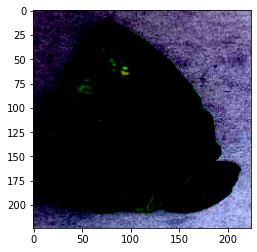

In [7]:
imgtest = None
for images, labels in dataloaders['train']:  
    imgtest = images[3]
    print(imgtest.shape)
    break

imgtest = imgtest.numpy()
imgtest = np.moveaxis(imgtest, 0, -1)
imshow(imgtest)

In [32]:
%cd /kaggle/working/EfficientNet-PyTorch

from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=15)
model = EfficientNet.from_name('efficientnet-b0', num_classes=15)

for param in model.parameters():
    param.requires_grad = True

dev = torch.device("cuda") 

/kaggle/working/EfficientNet-PyTorch


In [33]:
model = model.to(dev)

optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

## Training

- Train and validation is done in 1 epoch
- Trace train, val accuracy scores and losses
- Save the model which has the highest validation accuracy

- total number of train data = 12382
- train acc = corrects / 12382 * 100 = corrects * **0.008**
- total number of validation data = 4128
- val acc = corrects / 4128 * 100 = corrects * **0.0242**

In [34]:
num_epochs = 70
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0

since = time.time()
best_model = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    for i, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), '/kaggle/working/best_model.pt')
print("model saved")

epoch: 1/70 | trn loss: 2.4397 | val loss: 2.6638 | 1m 17s elapsed
best model updated-epoch: 1 | val_accuracy: 9.5832
epoch: 2/70 | trn loss: 2.0837 | val loss: 2.6841 | 2m 35s elapsed
epoch: 3/70 | trn loss: 1.7971 | val loss: 2.1895 | 3m 52s elapsed
best model updated-epoch: 3 | val_accuracy: 26.6684
epoch: 4/70 | trn loss: 1.5824 | val loss: 1.3879 | 5m 10s elapsed
best model updated-epoch: 4 | val_accuracy: 55.2002
epoch: 5/70 | trn loss: 1.3906 | val loss: 1.2409 | 6m 28s elapsed
best model updated-epoch: 5 | val_accuracy: 59.4836
epoch: 6/70 | trn loss: 1.2233 | val loss: 1.0294 | 7m 45s elapsed
best model updated-epoch: 6 | val_accuracy: 66.4532
epoch: 7/70 | trn loss: 1.0639 | val loss: 1.1148 | 9m 3s elapsed
epoch: 8/70 | trn loss: 0.9320 | val loss: 0.7965 | 10m 20s elapsed
best model updated-epoch: 8 | val_accuracy: 73.2534
epoch: 9/70 | trn loss: 0.8150 | val loss: 0.6921 | 11m 38s elapsed
best model updated-epoch: 9 | val_accuracy: 76.7866
epoch: 10/70 | trn loss: 0.7132 |

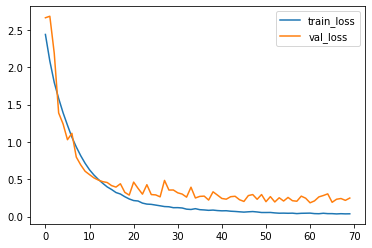

In [35]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

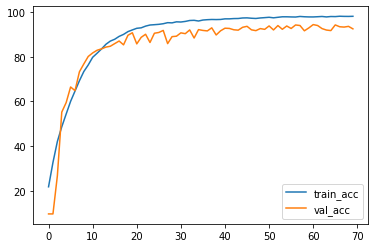

In [37]:
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [45]:
best_model = EfficientNet.from_name('efficientnet-b0', num_classes=15)
best_model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

best_model.to(dev)

''

In [50]:
corrects = 0
total = 0

model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

3808/4128 | test accuracy: 0.9225
